#Classificador de banhistas utilizando deep learning

#Functions

In [0]:
!git clone https://github.com/LeonardoMonte/ProjetoVisaoComputacional.git

import numpy as np
import random
import pandas as pd
import glob
import cv2
from sklearn.decomposition import PCA
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import time
from scipy.stats import friedmanchisquare
import matplotlib.pyplot as plt
from keras.models import model_from_json
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint  
from keras.layers.normalization import BatchNormalization
import tensorflow as tf


def loadfolderimgs(path):

    arrayphotos = []

    for img in glob.glob(path):
        n = cv2.imread(img)
        arrayphotos.append(n)

    return arrayphotos
  
def Turntogray(arrayphotos):

    size = len(arrayphotos)
    for x in range (0,size):
        arrayphotos[x] = cv2.cvtColor(arrayphotos[x], cv2.COLOR_BGR2GRAY)

    return arrayphotos
  
def gray3d(arrayphotos):
  
  return [np.atleast_3d(x) for x in arrayphotos]

def resizephotos(arrayphotos, size1, size2):

    size = len(arrayphotos)
    for x in range (0,size):
        arrayphotos[x] = cv2.resize(arrayphotos[x], (size1,size2))

    return arrayphotos
  
def binaryadaptive(arrayphotos,threshold,val1):

    for x in range(len(arrayphotos)):
        arrayphotos[x] = cv2.adaptiveThreshold(arrayphotos[x],threshold,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,val1,10)

    return arrayphotos

def invertbinaryphotos(arrayphotos):

    for x in range(len(arrayphotos)):
        arrayphotos[x] = cv2.bitwise_not(arrayphotos[x])

    return arrayphotos
  
  
def amostra_estrat(tam , df , classe):
    classes = df[classe].unique()
    qtde_por_classe = round(tam / len(classes))
    amostras_por_classe = []
    for c in classes:
        indices_c = df[classe] == c
        obs_c = df[indices_c]
        amostra_c = obs_c.sample(qtde_por_classe)
        amostras_por_classe.append(amostra_c)
    amostra_estratificada = pd.concat(amostras_por_classe)
    return amostra_estratificada
  
def normalize(df1):
    x = df1.values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(scaled)
    return df_normalized 
  
def PCAdataframe(pcanumber,dataframe):

    pca = PCA(n_components=pcanumber)
    dataframe = pca.fit_transform(dataframe)

    return dataframe  
  
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):

    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph
      

def sliding_window(image, stepSize, windowSize):
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
  
  
from skimage import feature
import numpy as np
 
class LocalBinaryPatterns:
  
    def __init__(self, numPoints, radius):
      # store the number of points and radius
      self.numPoints = numPoints
      self.radius = radius

    def describe(self, image, eps=1e-7):
      # compute the Local Binary Pattern representation
      # of the image, and then use the LBP representation
      # to build the histogram of patterns
      lbp = feature.local_binary_pattern(image, self.numPoints,
        self.radius, method="uniform")
      (hist, _) = np.histogram(lbp.ravel(),
        bins=np.arange(0, self.numPoints + 3),
        range=(0, self.numPoints + 2))

      # normalize the histogram
      hist = hist.astype("float")
      hist /= (hist.sum() + eps)

      # return the histogram of Local Binary Patterns
      return hist

    
def getHOGplusHU(arrayphotos):
    hog = cv2.HOGDescriptor()
    for x in range(len(arrayphotos)):
        aux = []


        h = hog.compute(arrayphotos[x]).flatten()

        for ho in h:
            aux.append(ho)

        hu = cv2.HuMoments(cv2.moments(arrayphotos[x]), True).flatten()

        for huu in hu:
            aux.append(huu)

        arrayphotos[x] = aux

    return arrayphotos

def getHOG(arrayphotos):
  
    hog = cv2.HOGDescriptor()
    for x in range(len(arrayphotos)):
        aux = []
        h = hog.compute(arrayphotos[x]).flatten()

        for ho in h:
            aux.append(ho)

        arrayphotos[x] = aux

    return arrayphotos
  
def getHU(arrayphotos):
  
    for x in range(len(arrayphotos)):
        aux = []
        hu = cv2.HuMoments(cv2.moments(arrayphotos[x]), True).flatten()

        for huu in hu:
            aux.append(huu)

        arrayphotos[x] = aux

    return arrayphotos

def getLBP(arrayphotos):

    lbp = LocalBinaryPatterns(24,8)
    for x in range(len(arrayphotos)):
        aux = []
        pbl = lbp.describe(arrayphotos[x])
        
        for a in pbl:
            aux.append(a)

        arrayphotos[x] = aux

    return arrayphotos
    
def getLBPplusHU(arrayphotos):

    lbp = LocalBinaryPatterns(24,8)
    for x in range(len(arrayphotos)):
        aux = []
        
        hu = cv2.HuMoments(cv2.moments(arrayphotos[x]), True).flatten()

        for huu in hu:
            aux.append(huu)
            
        pbl = lbp.describe(arrayphotos[x])
        
        for a in pbl:
            aux.append(a)

        arrayphotos[x] = aux

    return arrayphotos
    
def getHOGplusHUplusLBP(arrayphotos):
    hog = cv2.HOGDescriptor()
    lbp = LocalBinaryPatterns(24,8)
    for x in range(len(arrayphotos)):
        aux = []


        h = hog.compute(arrayphotos[x]).flatten()

        for ho in h:
            aux.append(ho)

        hu = cv2.HuMoments(cv2.moments(arrayphotos[x]), True).flatten()

        for huu in hu:
            aux.append(huu)
        
        pbl = lbp.describe(arrayphotos[x])
        
        for a in pbl:
            aux.append(a)
        
        arrayphotos[x] = aux

    return arrayphotos

def getHOGplusLBP(arrayphotos):
    hog = cv2.HOGDescriptor()
    lbp = LocalBinaryPatterns(24,8)
    for x in range(len(arrayphotos)):
        aux = []
        
        h = hog.compute(arrayphotos[x]).flatten()
        for ho in h:
            aux.append(ho)
            
        pbl = lbp.describe(arrayphotos[x])        
        for a in pbl:
            aux.append(a)
        
        arrayphotos[x] = aux

    return arrayphotos

Cloning into 'ProjetoVisaoComputacional'...
remote: Enumerating objects: 3951, done.
remote: Counting objects: 100% (3951/3951), done.
remote: Compressing objects: 100% (1243/1243), done.
remote: Total 3951 (delta 2708), reused 3951 (delta 2708), pack-reused 0
Receiving objects: 100% (3951/3951), 49.13 MiB | 27.70 MiB/s, done.
Resolving deltas: 100% (2708/2708), done.


Using TensorFlow backend.


#Pre processing CNN

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

positivas = loadfolderimgs('ProjetoVisaoComputacional/Images/testepositiva/*.jpg')
negativas = loadfolderimgs('ProjetoVisaoComputacional/Images/nova classe negativa/*.jpg')

positivas = resizephotos(positivas, 32, 32)
negativas = resizephotos(negativas, 32, 32)

positivas = positivas[:723]

#positivas = Turntogray(positivas)
#negativas = Turntogray(negativas)

#positivas = gray3d(positivas)
#negativas = gray3d(negativas)

positivas_labels = np.ones(len(positivas))
negativas_labels = np.zeros(len(negativas))

images_noclass = np.concatenate((positivas,negativas))
images_class = np.concatenate((positivas_labels,negativas_labels))

shuffle(images_noclass, images_class, random_state=0)

#X_train, X_test, y_train, y_test = train_test_split(np.array(images_noclass), np.array(images_class), test_size=0.3)

#X_train2, X_val, y_train2, y_val = train_test_split(np.array(X_train), np.array(y_train), test_size=0.3)


#Models CNN

In [0]:
def build_LeNet(width, height, depth, classes):
  # initialize the model
  model = Sequential()
  inputShape = (height, width, depth)

  # first set of CONV => RELU => POOL layers
  model.add(Conv2D(20, (5, 5), padding="same",
    input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # second set of CONV => RELU => POOL layers
  model.add(Conv2D(50, (5, 5), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(500))
  model.add(Activation("relu"))

  # softmax classifier
  model.add(Dense(classes))
  model.add(Activation("sigmoid"))
  
  #model.summary()
  
  # return the constructed network architecture
  return model

from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout

def build_MiniVGG(width, height, depth, classes):
  # initialize the model
  model = Sequential()
  inputShape = (height, width, depth)# first CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(32, (3, 3), padding="same",
  input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  # softmax classifier
  model.add(Dense(classes))
  model.add(Activation("sigmoid"))
  
  #model.summary()
  
  # return the constructed network architecture
  return model

#Main CNN


In [0]:
from keras import backend as K
from tensorflow.python.platform import gfile

model = build_LeNet(32,32,3,1)
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='binary_crossentropy', optimizer='adam', 
                 metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

#model.load_weights('ProjetoVisaoComputacional/Pesos MINIVGG/minivgg32321.hdf5')


#ite = 0
#array = []
#array.append(X_test[ite])

#result = model.predict_classes(np.array(array))[0][0]

#print(result)
#print(model.predict(np.array(array)))
#print(y_test[ite])
#frozen_graph = freeze_session(K.get_session(),
#                              output_names=[out.op.name for out in model.outputs])


#tf.train.write_graph(frozen_graph, "sample_data", "miniVGGBanhistas.pb", as_text=False)




#hist = model.fit(X_train2,y_train2, epochs=20, batch_size=64,validation_data=(X_val, y_val), callbacks=[checkpointer], shuffle= True)


#model.load_weights('model.weights.best.hdf5')

#score = model.evaluate(X_test, y_test, verbose=0)
#print('\n', 'Test accuracy:', score[1])



#Abordagem Classica

In [0]:
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal

############ PRE PROCESSAMENTO ###############

arrayphotospositiva = loadfolderimgs('ProjetoVisaoComputacional/Images/testepositiva/*.jpg') # Carrego as imagens
arrayphotosnegativa = loadfolderimgs('ProjetoVisaoComputacional/Images/nova classe negativa/*.jpg') # Carrego as imagens
arrayphotospositiva = Turntogray(arrayphotospositiva) # Transformo pra tom de cinza
arrayphotosnegativa = Turntogray(arrayphotosnegativa) # Transformo pra tom de cinza
arrayphotospositiva = binaryadaptive(arrayphotospositiva,255,27) # Binario
arrayphotosnegativa = binaryadaptive(arrayphotosnegativa,255,27) # Binario 
arrayphotospositiva = invertbinaryphotos(arrayphotospositiva) # Inverto 
arrayphotosnegativa = invertbinaryphotos(arrayphotosnegativa) # Inverto
arrayphotospositiva = resizephotos(arrayphotospositiva,64,128) # Mudo pro tamanho do HOG
arrayphotosnegativa = resizephotos(arrayphotosnegativa,64,128) # Mudo pro tamanho do HOG



#arrayphotospositiva = getHOGplusHUplusLBP(arrayphotospositiva) # HOG LBP E HU JUNTOS
#arrayphotosnegativa = getHOGplusHUplusLBP(arrayphotosnegativa) # HOG LBP E HU JUNTOS

#arrayphotospositiva = getHOGplusHU(arrayphotospositiva) # HOG E HU JUNTOS
#arrayphotosnegativa = getHOGplusHU(arrayphotosnegativa) # HOG E HU JUNTOS

#arrayphotospositiva = getHOGplusLBP(arrayphotospositiva) # HOG E LBP JUNTOS
#arrayphotosnegativa = getHOGplusLBP(arrayphotosnegativa) # HOG E LBP JUNTOS

arrayphotospositiva = getHOG(arrayphotospositiva) # HOG 
arrayphotosnegativa = getHOG(arrayphotosnegativa) # HOG

#arrayphotospositiva = getHU(arrayphotospositiva) # HU
#arrayphotosnegativa = getHU(arrayphotosnegativa) # HU

#arrayphotospositiva = getLBP(arrayphotospositiva) # LBP
#arrayphotosnegativa = getLBP(arrayphotosnegativa) # LBP

#arrayphotospositiva = getLBPplusHU(arrayphotospositiva) # HOG E LBP JUNTOS
#arrayphotosnegativa = getLBPplusHU(arrayphotosnegativa) # HOG E LBP JUNTOS




df1 = pd.DataFrame(arrayphotospositiva) # TRANSFORMO EM DATAFRAME
df2 = pd.DataFrame(arrayphotosnegativa) # TRANSFORMO EM DATAFRAME
df1['Class'] = 1 # ADICIONO CLASSE
df2['Class'] = 0 # ADICIONO CLASSE
frames = [df1,df2] # JUNTO OS DATAFRAMES
df_final = pd.concat(frames, ignore_index=True) # JUNTO OS DATAFRAMES
df_finalaux = df_final.copy() # CRIO COPIA PRA PODER FAZER PCA E NORMALIZAR
del df_final['Class'] # DELETO A CLASSE DO ORIGINAL
df_final = pd.DataFrame(PCAdataframe(50,df_final)) # FAÇO PCA E O PCA RETORNA UM ARRAY JA PASSO COMO DATAFRAME DNV
df_final = normalize(df_final) # NORMALIZO
df_final['Class'] = df_finalaux['Class'] # PASSO A CLASSE DA COPIA PRO ORIGINAL
df_final = amostra_estrat(1400, df_final, 'Class') # ESTRATIFICO OS DADOS


############################################

kfold = KFold(10,True,1)


##### MODELOS ######

modelmlp = Sequential()
modelmlp.add(Dense(15, input_dim = 50, activation="relu", name='dense1'))
#modelmlp.add(Dense(30,activation="relu",name = 'dense2'))
modelmlp.add(Dense(1, activation="sigmoid", name='dense3'))    
modelmlp.compile( loss='binary_crossentropy', optimizer="adam",metrics=['accuracy'])

svmlinear = SVC(kernel='linear') 
svmrbf = SVC(kernel='rbf' , gamma='scale')
logRegre = LogisticRegression(solver='lbfgs')

#####################

###### ARRAYS ######
svmlineararray = []
svmrbfarray = []
logRegrearray = []
mlparray = []

svmlineartime = []
svmrbftime = []
logRegretime = []
mlptime = []

###################


for x in range (5): # FOR QUE VAI REALIZAR O KFOLD DE 10 5 VEZES

    tempo1 = time.time()
    cols = list(df_final.columns)
    cols.remove('Class')
    df_images_noclass = df_final[cols]  # SEPARANDO EM DOIS DATAFRAMES UM COM A CLASSE E OUTRO SEM
    df_images_class = df_final['Class']
    c = kfold.split(df_final) # REALIZANDO O KFOLD DO MEU DATAFRAME NORMALIZADO

    for train_index, test_index in c:
        noclass_train, noclass_test = df_images_noclass.iloc[train_index], df_images_noclass.iloc[test_index]
        class_train, class_test = df_images_class.iloc[train_index], df_images_class.iloc[test_index]

        svmlinearstart = time.time()
        svmlinear.fit(noclass_train,class_train)
        svmlineararray.append(svmlinear.score(noclass_test, class_test))
        #print(confusion_matrix(class_test, svmlinear.predict(noclass_test)))
        svmlinearend = time.time()
        svmlineartime.append(svmlinearend - svmlinearstart)

        svmrbfstart = time.time()
        svmrbf.fit(noclass_train,class_train)
        svmrbfarray.append(svmrbf.score(noclass_test, class_test))
        #print(confusion_matrix(class_test, svmrbf.predict(noclass_test)))
        svmrbfend = time.time()
        svmrbftime.append(svmrbfend - svmrbfstart)

        logRegrestart = time.time()
        logRegre.fit(noclass_train,class_train)
        logRegrearray.append(logRegre.score(noclass_test,class_test))
        #print(confusion_matrix(class_test, logRegre.predict(noclass_test)))
        logRegreend = time.time()
        logRegretime.append(logRegreend - logRegrestart)

        mlpstart = time.time()
        modelmlp.fit(np.array(noclass_train), np.array(class_train), epochs=200, batch_size=256, verbose = False)
        mlparray.append(modelmlp.evaluate(np.array(noclass_test),np.array(class_test),verbose = False)[1])
        #print(confusion_matrix(class_test, modelmlp.predict_classes(np.array(noclass_test))))
        mlpend = time.time()
        mlptime.append(mlpend - mlpstart)

    df_final = df_final.sample(frac=1)

mediasvmlinear = np.mean(svmlineararray) # FUNÇÕES QUE REALIZAM A MODA MEDIA E MEDIANA DA SVM LINEAR
medianasvmlinear = np.median(svmlineararray)
stdsvmlinear = np.std(svmlineararray)
timesvmlinear = np.mean(svmlineartime)  
    
print("\n\n-------------- SVM LINEAR ---------------")
print("Media: ", mediasvmlinear)
print("Mediana: ", medianasvmlinear)
print("Desvio padrão: ", stdsvmlinear)
print("Tempo médio: ", timesvmlinear)

mediasvmrbf = np.mean(svmrbfarray) # FUNÇÕES QUE REALIZAM A MODA MEDIA E MEDIANA DA SVM RBF
medianasvmrbf = np.median(svmrbfarray)
stdsvmrbf = np.std(svmrbfarray)
timesvmrbf = np.mean(svmrbftime)

print("\n\n-------------- SVM RBF ---------------")
print("Media: ", mediasvmrbf)
print("Mediana: ", medianasvmrbf)
print("Desvio padrão: ", stdsvmrbf)
print("Tempo médio: ", timesvmrbf)


medialogregre = np.mean(logRegrearray)
medianalogregre = np.median(logRegrearray)
stdlogregre = np.std(logRegrearray)
timelogregre = np.mean(logRegretime)

print("\n\n-------------- REGRESSAO LOGISTICA ---------------")
print("Media: ", medialogregre)
print("Mediana: ", medianalogregre)
print("Desvio padrão: ", stdlogregre)
print("Tempo médio: ", timelogregre)

mediann = np.mean(mlparray)
medianann = np.median(mlparray)
stdnn = np.std(mlparray)
timenn = np.median(mlptime)

print("\n\n-------------- MLP ---------------")
print("Media: ", mediann)
print("Mediana: ", medianann)
print("Desvio padrão: ", stdnn)
print("Tempo médio: ", timenn)




# RESULTS PLOT

In [0]:
datacsv = []

for ite in range(len(svmrbfarray)):
    aux = []
    aux.append(svmlineararray[ite])
    aux.append(svmrbfarray[ite])
    aux.append(logRegrearray[ite])
    aux.append(mlparray[ite])

    datacsv.append(aux)
    
stat, p = friedmanchisquare(svmlineararray,svmrbfarray,logRegrearray, mlparray)

datacsv = pd.DataFrame(datacsv, columns=['SVMLINEAR','SVMRBF','LOGREG','MLP'])
print(datacsv)

dataplot = datacsv.boxplot(column=['SVMLINEAR','SVMRBF','LOGREG','MLP'],figsize=(12,8))
plt.xlabel('Algorithms')
plt.ylabel('Acuracy score')
plt.title('P-value:'+ str(p))

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), svmlineararray, label="SVM LINEAR" )
plt.plot(np.arange(0, 50), svmrbfarray, label="SVM RBF")
plt.plot(np.arange(0, 50), logRegrearray, label="REG LOG" )
plt.plot(np.arange(0, 50), mlparray, label="MLP")
#plt.plot(np.arange(0, 100), cnnarray, label="CNN")
plt.title("Test Accuracy")
plt.xlabel("Ite")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#KFOLD CNN

In [0]:
from sklearn.model_selection import KFold
k = KFold(10,True,1)

cnnarray = []
cont = 0

for x in range(5):
  for train_index,test_index in k.split(images_noclass):
    X_trainK, X_testK = np.array(images_noclass)[train_index], np.array(images_noclass)[test_index]
    y_trainK, y_testK = np.array(images_class)[train_index], np.array(images_class)[test_index]


    hist = model.fit(X_trainK,y_trainK, epochs=20, batch_size=256,verbose = False)
    #model.load_weights('model.weights.best.hdf5')
    score = model.evaluate(X_testK, y_testK, verbose=0)
    print('\n', 'Test accuracy:', score[1])
    cnnarray.append(score[1])
  
  shuffle(images_noclass, images_class, random_state=cont)
  cont += 1
print(np.mean(cnnarray))


 Test accuracy: 0.8413793107558941

 Test accuracy: 0.8275862085408178

 Test accuracy: 0.9034482762731355

 Test accuracy: 0.9862068969627906


In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), hist.history["loss"], label="train_loss" )
plt.plot(np.arange(0, 20), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), hist.history["acc" ], label="train_acc" )
plt.plot(np.arange(0, 20), hist.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

# SLINDING WINDOW

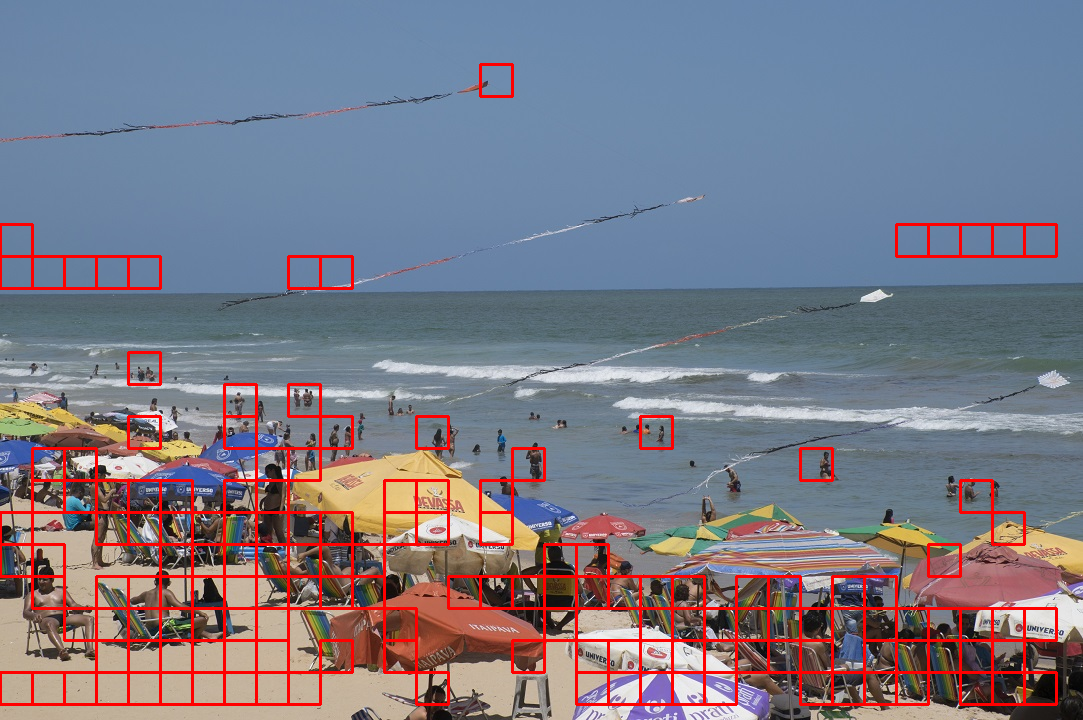

In [0]:
from skimage.transform import pyramid_gaussian
import cv2
from google.colab.patches import cv2_imshow

images = loadfolderimgs('ProjetoVisaoComputacional/Images/*jpg')  
copys = []
for im in images:
  copys.append(im.copy())

(winH,winW) = (32,32)
rectangles = []
images = Turntogray(images)
images = gray3d(images)

#for (i, resized) in enumerate(pyramid_gaussian(images[0], downscale=2)):
#    if resized.shape[0] < 30 or resized.shape[1] < 30:
#        break

for (x, y, window) in sliding_window(images[0], stepSize=32, windowSize=(winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue

    array = []
    array.append(np.atleast_3d(window))
    result = model.predict_classes(np.array(array))[0][0]

    if result == 1:
      rectangles.append((x,y,x+winW,y+winH))
        
for (x,y,h1,h2) in rectangles:
    cv2.rectangle(copys[0],(x,y),(h1,h2),(0,0,255),2)
    
cv2_imshow(copys[0])